In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os

In [ ]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if needed
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/CsvData/emails.csv')

In [ ]:
data.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
data.shape

(5728, 2)

In [ ]:
data.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
5723,False
5724,False
5725,False
5726,False


In [ ]:
data.duplicated().sum()

33

Text(0.5, 1.0, 'Spam vs Not Spam Email Count')

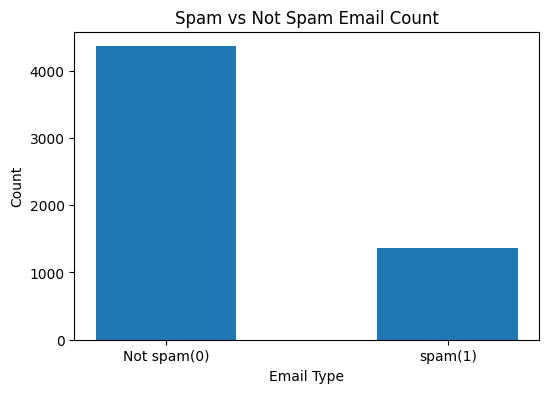

In [ ]:
spam_count =data['spam'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(['Not spam(0)','spam(1)'],[spam_count[0],spam_count[1]],width=0.5)
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.title("Spam vs Not Spam Email Count")

In [ ]:
data.isnull().sum()

,0
text,0
spam,0


## Data Preprocessing .

In [ ]:
# Best practice for your case
data = data.drop_duplicates(subset='text')
data.reset_index(drop=True, inplace=True)
# Check to confirm
print("✅ Remaining rows after removing duplicates:", len(data))
print("🔁 Duplicate rows now:", data.duplicated().sum())

✅ Remaining rows after removing duplicates: 5695
🔁 Duplicate rows now: 0


### Text Preprocessing

In [ ]:
#covert Upper case to Lowercase
import re
import string

In [ ]:
data['text'] = data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))


In [ ]:
data.head()

,text,spam
0,subject: naturally irresistible your corporate...,1
1,subject: the stock trading gunslinger fanny is...,1
2,subject: unbelievable new homes made easy im w...,1
3,subject: 4 color printing special request addi...,1
4,"subject: do not have money , get software cds ...",1


In [ ]:
data['text'].head()

,text
0,subject: naturally irresistible your corporate...
1,subject: the stock trading gunslinger fanny is...
2,subject: unbelievable new homes made easy im w...
3,subject: 4 color printing special request addi...
4,"subject: do not have money , get software cds ..."


In [ ]:

# Remove "subject:" from beginning of text (case insensitive)
data['text'] = data['text'].str.replace(r'(?i)^subject:\s*', '', regex=True)


In [ ]:
data['text'].head()

,text
0,naturally irresistible your corporate identity...
1,the stock trading gunslinger fanny is merrill ...
2,unbelievable new homes made easy im wanting to...
3,4 color printing special request additional in...
4,"do not have money , get software cds from here..."


### Remove LINK

In [ ]:
# Step 2: Remove URLs (http, https, www)
data['text'] = data['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)

In [ ]:
import string

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Remove Panctuation

In [ ]:

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

# Apply the function to the 'text' column
data['text'] = data['text'].apply(remove_punctuations)

In [ ]:
data['text'].head(10)

,text
0,naturally irresistible your corporate identity...
1,the stock trading gunslinger fanny is merrill ...
2,unbelievable new homes made easy im wanting to...
3,4 color printing special request additional in...
4,do not have money get software cds from here ...
5,great nnews hello welcome to medzonline sh gr...
6,here s a hot play in motion homeland security...
7,save your money buy getting this thing here yo...
8,undeliverable home based business for grownup...
9,save your money buy getting this thing here yo...


### Remove Numbers

In [ ]:
import re

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Apply the function to the 'text' column
data['text'] = data['text'].apply(remove_numbers)


In [ ]:
data['text'].head(10)

,text
0,naturally irresistible your corporate identity...
1,the stock trading gunslinger fanny is merrill ...
2,unbelievable new homes made easy im wanting to...
3,color printing special request additional inf...
4,do not have money get software cds from here ...
5,great nnews hello welcome to medzonline sh gr...
6,here s a hot play in motion homeland security...
7,save your money buy getting this thing here yo...
8,undeliverable home based business for grownup...
9,save your money buy getting this thing here yo...


### Remove stopWords

In [ ]:
import nltk

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the function
data['text'] = data['text'].apply(remove_stopwords)


In [ ]:
data['text'].head(10)

,text
0,naturally irresistible corporate identity lt r...
1,stock trading gunslinger fanny merrill muzo co...
2,unbelievable new homes made easy im wanting sh...
3,color printing special request additional info...
4,money get software cds software compatibility ...
5,great nnews hello welcome medzonline sh ground...
6,hot play motion homeland security investments ...
7,save money buy getting thing tried cialls yet ...
8,undeliverable home based business grownups mes...
9,save money buy getting thing tried cialls yet ...


### Stemming

In [ ]:
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download 'punkt' tokenizer data (only needed once)
nltk.download('punkt',download_dir='Sentiment Analysis/steeming')


[nltk_data] Downloading package punkt to Sentiment
[nltk_data]     Analysis/steeming...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data['text'].head(10)

,text
0,naturally irresistible corporate identity lt r...
1,stock trading gunslinger fanny merrill muzo co...
2,unbelievable new homes made easy im wanting sh...
3,color printing special request additional info...
4,money get software cds software compatibility ...
5,great nnews hello welcome medzonline sh ground...
6,hot play motion homeland security investments ...
7,save money buy getting thing tried cialls yet ...
8,undeliverable home based business grownups mes...
9,save money buy getting thing tried cialls yet ...


In [ ]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
data['text'] = data['text'].apply(lambda x: " ".join(ps.stem(word) for word in x.split()))


In [ ]:
data['text'].head(10)

,text
0,natur irresist corpor ident lt realli hard rec...
1,stock trade gunsling fanni merril muzo colza a...
2,unbeliev new home made easi im want show homeo...
3,color print special request addit inform click...
4,money get softwar cd softwar compat great grow...
5,great nnew hello welcom medzonlin sh groundsel...
6,hot play motion homeland secur invest terror a...
7,save money buy get thing tri ciall yet cannot ...
8,undeliver home base busi grownup messag subjec...
9,save money buy get thing tri ciall yet cannot ...


## Building Vocabulary

In [ ]:
from collections import Counter
vocab= Counter()

In [ ]:
for sentence in data['text']:
    vocab.update(sentence.split())


In [ ]:
vocab

Counter({'natur': 348,
         'irresist': 4,
         'corpor': 565,
         'ident': 102,
         'lt': 30,
         'realli': 413,
         'hard': 200,
         'recollect': 29,
         'compani': 2286,
         'market': 2734,
         'full': 465,
         'suqgest': 14,
         'inform': 2683,
         'isoverwhelminq': 7,
         'good': 1086,
         'catchi': 24,
         'logo': 273,
         'stylish': 15,
         'statloneri': 15,
         'outstand': 102,
         'websit': 697,
         'make': 1879,
         'task': 102,
         'much': 854,
         'easier': 87,
         'promis': 166,
         'havinq': 9,
         'order': 1208,
         'iogo': 29,
         'automaticaili': 5,
         'becom': 324,
         'world': 472,
         'ieader': 16,
         'isguit': 13,
         'ciear': 9,
         'without': 389,
         'product': 1195,
         'effect': 470,
         'busi': 2294,
         'organ': 354,
         'practic': 208,
         'aim': 73,
     

In [ ]:
len(vocab)

25671

In [ ]:
data.shape

(5695, 2)

In [ ]:
tokens = [key for key in vocab if vocab[key] > 20]


In [ ]:
len(tokens)

3652

In [ ]:
import os

def save_vocabulary(tokens, filename):
    """
    Save vocabulary tokens to a text file

    Args:
        tokens: list of vocabulary words
        filename: path where to save the file
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Write tokens to file (one word per line)
    with open(filename, 'w', encoding='utf-8') as file:
        for token in tokens:
            file.write(f"{token}\n")

    # Get full path and confirm save
    full_path = os.path.abspath(filename)
    print(f"✅ Vocabulary saved successfully!")
    print(f"📁 File location: {full_path}")
    print(f"📊 Total words saved: {len(tokens)}")

    return full_path

# Save your vocabulary
# Replace 'tokens' with your actual vocabulary list
vocabulary_path = "vocabulary/vocab.txt"
save_vocabulary(vocab, vocabulary_path)

✅ Vocabulary saved successfully!
📁 File location: /content/vocabulary/vocab.txt
📊 Total words saved: 25671


'/content/vocabulary/vocab.txt'

### Divide data

In [ ]:
data

,text,spam
0,natur irresist corpor ident lt realli hard rec...,1
1,stock trade gunsling fanni merril muzo colza a...,1
2,unbeliev new home made easi im want show homeo...,1
3,color print special request addit inform click...,1
4,money get softwar cd softwar compat great grow...,1
...,...,...
5690,research develop charg gpg forward shirley cre...,0
5691,receipt visit jim thank invit visit lsu shirle...,0
5692,enron case studi updat wow day super thank muc...,0
5693,interest david pleas call shirley crenshaw ass...,0


In [ ]:
x= data['text']
y= data['spam']

In [ ]:
x

,text
0,natur irresist corpor ident lt realli hard rec...
1,stock trade gunsling fanni merril muzo colza a...
2,unbeliev new home made easi im want show homeo...
3,color print special request addit inform click...
4,money get softwar cd softwar compat great grow...
...,...
5690,research develop charg gpg forward shirley cre...
5691,receipt visit jim thank invit visit lsu shirle...
5692,enron case studi updat wow day super thank muc...
5693,interest david pleas call shirley crenshaw ass...


In [ ]:
y

,spam
0,1
1,1
2,1
3,1
4,1
...,...
5690,0
5691,0
5692,0
5693,0


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

In [ ]:
x_train.shape

(4556,)

In [ ]:
x_test

,text
5668,explor data root energi oil suppli chain consu...
3455,alp present behalf enron corp would like invit...
2408,organis announc introduc enron global market e...
2465,loos end norma thank mesag shall ask krishna r...
3783,magic level nikkei forward leann walton na enr...
...,...
4092,fw meet follow dan sent inform follow meet wee...
1672,term project dear vinc wonder abl open attach ...
4357,carnegi mellon kristin present went quit well ...
3966,mscf speaker seri pierr philipp time present f...


### Vectorization

In [ ]:
import numpy as np

def vectorizer(ds, vocabulary):
    vectorized_lst = []
    for sentence in ds:
        sentence_lst = np.zeros(len(vocabulary))
        for i in range(len(vocabulary)):
            if vocabulary[i] in sentence.split():
                sentence_lst[i] = 1
        vectorized_lst.append(sentence_lst)
    vectorized_lst_new = np.array(vectorized_lst, dtype=np.float32)
    return vectorized_lst_new


In [ ]:
vectorize_x_train = vectorizer(x_train,tokens)

In [ ]:
vectorize_x_train


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
vectorize_x_test = vectorizer(x_test,tokens)

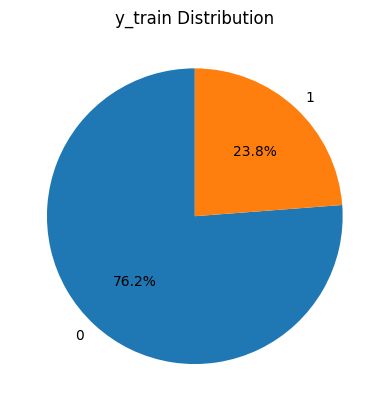

In [ ]:
pd.Series(y_train).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("y_train Distribution")
plt.ylabel("")  # Remove y-label for better pie chart display
plt.show()

In [ ]:
y_train.value_counts()

,count
spam,
0,3472
1,1084


### handel imblance dataset


In [ ]:
!pip install imbalanced-learn

In [ ]:

!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
vectorized_x_train_smote, y_train_smote = smote.fit_resample(vectorize_x_train, y_train)

print(vectorized_x_train_smote.shape, y_train_smote.shape)

(6944, 3652) (6944,)


In [ ]:
y_train_smote.value_counts()

,count
spam,
0,3472
1,3472


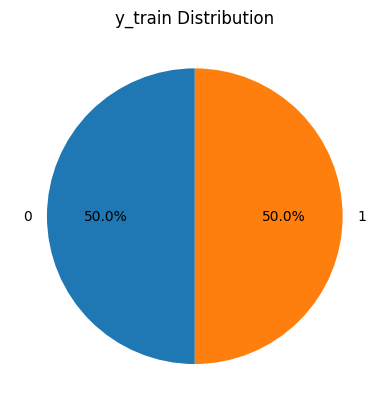

In [ ]:
pd.Series(y_train_smote).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("y_train Distribution")
plt.ylabel("")  # Remove y-label for better pie chart display
plt.show()

### **Model** **Tranning**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- Training scores ---
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    ppr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)

    print("Training scores:")
    print(f"\tAccuracy  = {acc}")
    print(f"\tPrecision = {ppr}")
    print(f"\tRecall    = {rec}")
    print(f"\tF1 Score  = {f1}")
    plot_confusion(y_act, y_pred, title="Confusion Matrix - Training")

# --- Validation scores ---
def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    ppr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)

    print("Validation scores:")
    print(f"\tAccuracy  = {acc}")
    print(f"\tPrecision = {ppr}")
    print(f"\tRecall    = {rec}")
    print(f"\tF1 Score  = {f1}")
    plot_confusion(y_act, y_pred, title="Confusion Matrix - Validation")

# --- Confusion matrix plot ---
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Not Spam", "Spam"],
                yticklabels=["Not Spam", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## **LogisticRegression**

In [ ]:
lr = LogisticRegression()
lr.fit(vectorized_x_train_smote, y_train_smote)

LogisticRegression()

In [ ]:
y_train_pred = lr.predict(vectorized_x_train_smote)

In [ ]:
y_train_pred

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
y_train_smote

,spam
0,0
1,0
2,0
3,0
4,1
...,...
6939,1
6940,1
6941,1
6942,1


Training scores:
	Accuracy  = 1.0
	Precision = 0.999
	Recall    = 1.0
	F1 Score  = 1.0


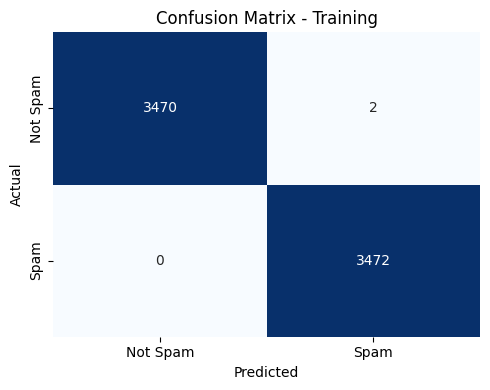

In [ ]:
training_scores(y_train_smote, y_train_pred)

In [ ]:
y_test_pred = lr.predict(vectorize_x_test)

Validation scores:
	Accuracy  = 0.989
	Precision = 0.959
	Recall    = 0.996
	F1 Score  = 0.978


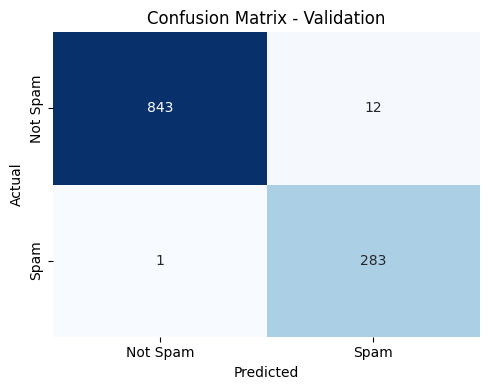

In [ ]:
validation_scores(y_test, y_test_pred)

## **Support Vector Machine**

In [ ]:
svm = LinearSVC()
svm.fit(vectorized_x_train_smote, y_train_smote)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
y_train_pred = svm.predict(vectorized_x_train_smote)

Training scores:
	Accuracy  = 1.0
	Precision = 1.0
	Recall    = 1.0
	F1 Score  = 1.0


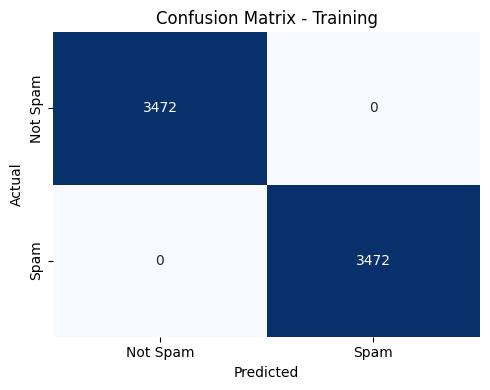

In [ ]:
training_scores(y_train_smote, y_train_pred)

In [ ]:
y_test_pred = svm.predict(vectorize_x_test)

Validation scores:
	Accuracy  = 0.987
	Precision = 0.972
	Recall    = 0.975
	F1 Score  = 0.974


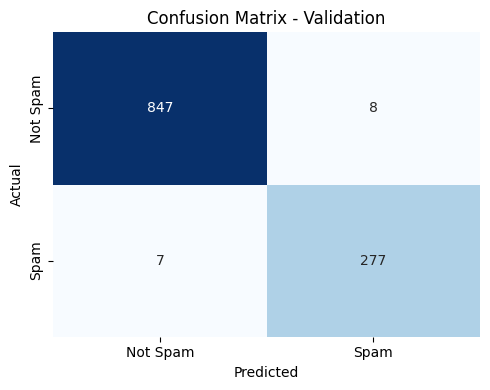

In [ ]:
validation_scores(y_test, y_test_pred)

## **Random Forest**


In [ ]:
rf =  RandomForestClassifier()
rf.fit(vectorized_x_train_smote, y_train_smote)

RandomForestClassifier()

In [ ]:
y_train_pred = rf.predict(vectorized_x_train_smote)

Training scores:
	Accuracy  = 1.0
	Precision = 1.0
	Recall    = 1.0
	F1 Score  = 1.0


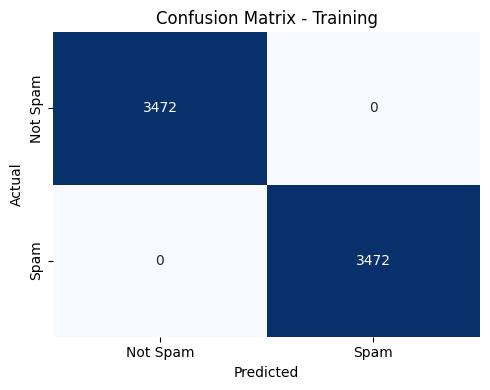

In [ ]:
training_scores(y_train_smote, y_train_pred)

In [ ]:
y_test_pred = rf.predict(vectorize_x_test)

Validation scores:
	Accuracy  = 0.978
	Precision = 0.978
	Recall    = 0.933
	F1 Score  = 0.955


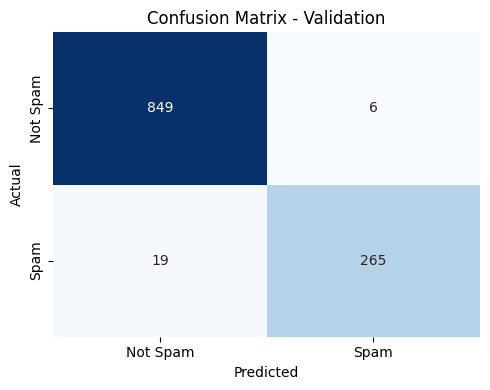

In [ ]:
validation_scores(y_test, y_test_pred)

## **Naive Bayes**

In [ ]:
MultinomialNB
nb =  MultinomialNB()
nb.fit(vectorized_x_train_smote, y_train_smote)

MultinomialNB()

Training scores:
	Accuracy  = 0.992
	Precision = 0.991
	Recall    = 0.993
	F1 Score  = 0.992


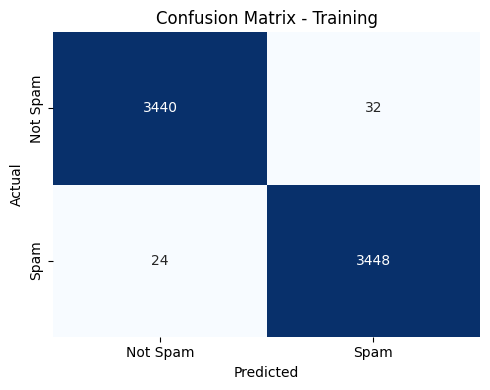

Validation scores:
	Accuracy  = 0.978
	Precision = 0.978
	Recall    = 0.933
	F1 Score  = 0.955


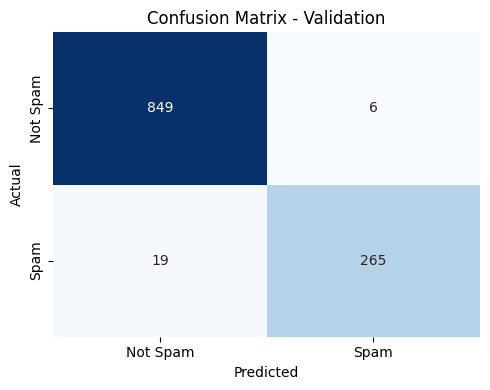

In [ ]:
y_train_pred = nb.predict(vectorized_x_train_smote)
training_scores(y_train_smote, y_train_pred)
y_test_pred = rf.predict(vectorize_x_test)
validation_scores(y_test, y_test_pred)

In [ ]:
import pickle
# Save the model as a pickle file
with open("/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/bestModel/Modelsvm.pkl", "wb") as file:
    pickle.dump(svm, file)

print("✅ Model saved as 'best_model.pkl'")


✅ Model saved as 'best_model.pkl'


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# --- Example Models ---
models = {
    "Naive_Bayes": MultinomialNB(),
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Random_Forest": RandomForestClassifier()
}

# --- Set your Google Drive path ---
save_path = "/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages"
os.makedirs(save_path, exist_ok=True)

# --- Function to Evaluate and Save Confusion Matrix ---
def evaluate_and_save_confusion(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = round(accuracy_score(y_test, y_pred), 3)
    prec = round(precision_score(y_test, y_pred), 3)
    rec = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)

    print(f"\n{name} Results:")
    print(f"Accuracy : {acc}, Precision : {prec}, Recall : {rec}, F1 : {f1}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Not Spam", "Spam"],
                yticklabels=["Not Spam", "Spam"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()

    # Full file path for saving
    filename = os.path.join(save_path, f"{name}_confusion_matrix.jpg")
    plt.savefig(filename, format='jpg')
    plt.close()
    print(f"📁 Saved confusion matrix as: {filename}")

# --- Run for all models ---
for model_name, model in models.items():
    evaluate_and_save_confusion(model_name, model,
                                 vectorized_x_train_smote, y_train_smote,
                                 vectorize_x_test, y_test)



Naive_Bayes Results:
Accuracy : 0.985, Precision : 0.968, Recall : 0.972, F1 : 0.97
📁 Saved confusion matrix as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Naive_Bayes_confusion_matrix.jpg

Logistic_Regression Results:
Accuracy : 0.989, Precision : 0.959, Recall : 0.996, F1 : 0.978
📁 Saved confusion matrix as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Logistic_Regression_confusion_matrix.jpg


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



SVM Results:
Accuracy : 0.987, Precision : 0.972, Recall : 0.975, F1 : 0.974
📁 Saved confusion matrix as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/SVM_confusion_matrix.jpg

Random_Forest Results:
Accuracy : 0.973, Precision : 0.97, Recall : 0.919, F1 : 0.944
📁 Saved confusion matrix as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Random_Forest_confusion_matrix.jpg


In [ ]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.7 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# --- Example Models ---
models = {
    "Naive_Bayes": MultinomialNB(),
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Random_Forest": RandomForestClassifier()
}

# --- Set your Google Drive path ---
save_path = "/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages"
os.makedirs(save_path, exist_ok=True)

# --- Function to Save PDF Report ---
def save_pdf_report(name, acc, prec, rec, f1):
    pdf_path = os.path.join(save_path, f"{name}_report.pdf")
    c = canvas.Canvas(pdf_path, pagesize=letter)
    c.setFont("Helvetica-Bold", 14)
    c.drawString(72, 750, f"Evaluation Report: {name}")
    c.setFont("Helvetica", 12)
    c.drawString(72, 720, f"Accuracy  : {acc}")
    c.drawString(72, 700, f"Precision : {prec}")
    c.drawString(72, 680, f"Recall    : {rec}")
    c.drawString(72, 660, f"F1 Score  : {f1}")
    c.save()
    print(f"📄 Saved PDF report as: {pdf_path}")

# --- Function to Evaluate and Save Confusion Matrix + PDF ---
def evaluate_and_save_confusion(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = round(accuracy_score(y_test, y_pred), 3)
    prec = round(precision_score(y_test, y_pred), 3)
    rec = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)

    print(f"\n{name} Results:")
    print(f"Accuracy : {acc}, Precision : {prec}, Recall : {rec}, F1 : {f1}")

    # Save confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Not Spam", "Spam"],
                yticklabels=["Not Spam", "Spam"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()

    filename = os.path.join(save_path, f"{name}_confusion_matrix.jpg")
    plt.savefig(filename, format='jpg')
    plt.close()
    print(f"🖼️  Saved confusion matrix as: {filename}")

    # Save report PDF
    save_pdf_report(name, acc, prec, rec, f1)

# --- Run for all models ---
for model_name, model in models.items():
    evaluate_and_save_confusion(model_name, model,
                                 vectorized_x_train_smote, y_train_smote,
                                 vectorize_x_test, y_test)



Naive_Bayes Results:
Accuracy : 0.985, Precision : 0.968, Recall : 0.972, F1 : 0.97
🖼️  Saved confusion matrix as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Naive_Bayes_confusion_matrix.jpg
📄 Saved PDF report as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Naive_Bayes_report.pdf

Logistic_Regression Results:
Accuracy : 0.989, Precision : 0.959, Recall : 0.996, F1 : 0.978
🖼️  Saved confusion matrix as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Logistic_Regression_confusion_matrix.jpg
📄 Saved PDF report as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Logistic_Regression_report.pdf


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



SVM Results:
Accuracy : 0.987, Precision : 0.972, Recall : 0.975, F1 : 0.974
🖼️  Saved confusion matrix as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/SVM_confusion_matrix.jpg
📄 Saved PDF report as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/SVM_report.pdf

Random_Forest Results:
Accuracy : 0.976, Precision : 0.978, Recall : 0.926, F1 : 0.951
🖼️  Saved confusion matrix as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Random_Forest_confusion_matrix.jpg
📄 Saved PDF report as: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/evaluationmtrixImages/Random_Forest_report.pdf
